The below content provided is evidence and background work towards the research paper titled:
## Predicting COVID-19 Mortality: A Comparative Study of Supervised Learning Models and Sex-Specific Risk Factors

Compiled by Grant Howe, In partial contribution to the module of "Applied Data Analysis and Research Methodology", led by Dr. Imran Ahmed

## 1. Importing Necessary Libraries

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification

## 2. Importing Dataset
(kaggle source file: https://www.kaggle.com/datasets/meirnizri/covid19-dataset/data)

In [171]:
df= pd.read_csv("Covid Data.csv")
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## 3. Preprocessing

In [173]:
#The death date is being converted into a binary output. Negative class (0) = Patient survived.
#Positive class (1) = Patient died. This will be my target column.

def death(date):
  if "9999" in str(date): #Data source says all dates in format 99/99/9999 represent a patient NOT dying.
    date = 0 #Assigning this above case to the negative class.
  else:
    date=1 #Otherwise assigning to the positive class.
  return date
df["died?"]= df["DATE_DIED"].apply(death) #Target column!
df= df.drop("DATE_DIED", axis=1) #This column is now irrelevant.

In [175]:
cols = list(df.columns)
missing_value_cols= []
for i in cols:
  if any(val in df[i].values for val in [97, 98, 99]): #rather than using NaN, values of 97,98,99 represent null values.
    if i != "AGE": #97,98,99 are still valid ages!
      missing_value_cols.append(i)
#The majority of the columns in the output are categorical- my approach will be to replace columns with missing data with their nodal values.

In [177]:
from sklearn.impute import SimpleImputer
for i in missing_value_cols: 
  df[i]=df[i].replace([97,98,99],np.nan) #An imputer replaces NaN values hence I must correctly format null variables.
imputer= SimpleImputer(missing_values=np.nan, strategy="most_frequent") #modal value imputations.
df[missing_value_cols]= imputer.fit_transform(df[missing_value_cols])

In [179]:
#Data Source claims that 'CLASSIFICATION_FINAL' refers to the extent to which the patient carried covid.
#1 is the highest and 4 or above means patients didn't have covid.

#Step 1- remove all rows with values >=4 as I am exploring risk factors for a patient WITH COVID dying
#Step 2- A patient dying is assigned to positive class. The classification is an ordinal column, where 
#higher risk should have a larger weighting. Values are to be re-assigned.

df= df[df["CLASIFFICATION_FINAL"]<4].copy() #Patients need to have at-least HAD covid to stay in data frame.
df["CLASIFFICATION_FINAL"]= df["CLASIFFICATION_FINAL"].map({1: 3, 3: 1, 2: 2})

In [181]:
cols= list(df.columns)
cols.remove("AGE") #age must not be encoded
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
for i in cols:
  df[i]= le.fit_transform(df[i]) #Makes training of ML models less complex.

In [183]:
df=df.drop(columns= ["MEDICAL_UNIT"], axis=1)
#Data source has little background info of this variable. Furthermore it ranges 1-12. This 
#may act as noise and hence is removed under the assumption that each medical unit has the same
#standard of care.

In [185]:
df_female= df[df["SEX"]==0] #I am investigating any contrast between health factors between men and women!
df_male= df[df["SEX"]==1]

df_female= df_female.drop("SEX", axis=1)
df_male= df_male.drop("SEX", axis=1)
#Data has been seperated according to SEX, so this column has 0 variability! Solution: remove it.

In [187]:
df_male= df_male.drop("PREGNANT", axis=1) #Biological males cannot be pregnant

## Exploratory Data Analysis (EDA)

Number of Patients admitted with Covid: 391979


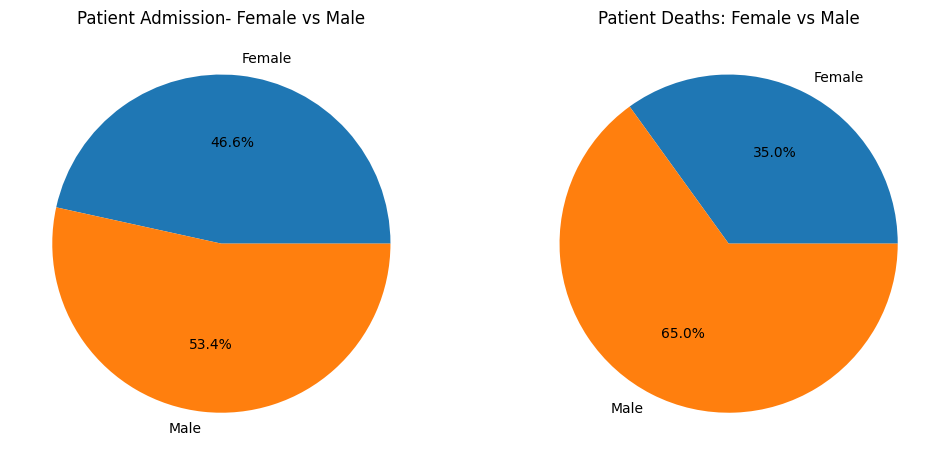

In [190]:
print(f"Number of Patients admitted with Covid: {len(df)}")
sex_admitted= df.groupby("SEX").size().reset_index(name="Count")
df_death= df.loc[df["died?"]==1].copy()
sex_death= df_death.groupby("SEX").size().reset_index(name="Count")
labels= ["Female", "Male"]
fig, axs= plt.subplots(1,2,figsize=(12, 6))
plt.sca(axs[0])
plt.pie(sex_admitted["Count"], labels=labels, autopct="%1.1f%%");
plt.title("Patient Admission- Female vs Male")
plt.sca(axs[1])
plt.pie(sex_death["Count"], labels=labels, autopct="%1.1f%%")
plt.title("Patient Deaths: Female vs Male");

,Health Condition?,Count
0,0,4
1,1,54232


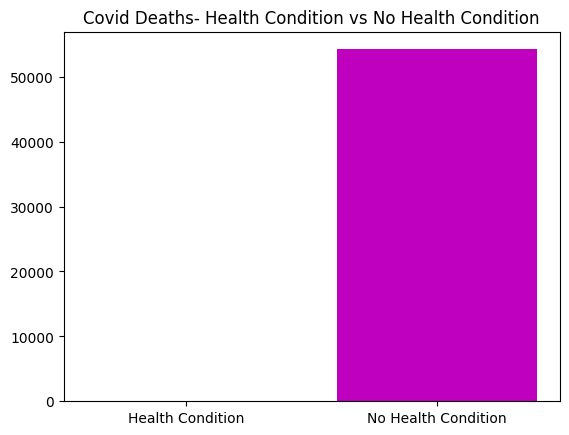

In [194]:
#Since columns representing various health condiions are binary an average of them will still be binary
df_death.loc[:,"Health Condition?"] = df_death[["DIABETES", "OBESITY", "CARDIOVASCULAR", "RENAL_CHRONIC", "OTHER_DISEASE", "COPD", "ASTHMA", "HIPERTENSION"]].max(axis=1)
health_condition_death= df_death.groupby("Health Condition?").size().reset_index(name="Count")
labels= ["Health Condition", "No Health Condition"]
plt.bar(labels, health_condition_death["Count"], color= "m");
plt.title("Covid Deaths- Health Condition vs No Health Condition")
health_condition_death
health_condition_death

## The above EDA tells us that:

- Nearly 100% of patients admitted with Covid had some underlying health condition
- The proportion of male patients who died from covid is noticably greater than that for female patients

## 5. Feature Selection

As outlined in the paper, these steps are to be performed SEPERATELY for men and women, 
to observe if any contast exists between correlating underlying health conditions and the best-suited ML algorithms.

My chosen data has exceptionaly high dimensionality. It is hence important to utilize a wide range of correlation measures to select which features have the highest importance.

Most features are binary (discrete). The Variance is hence low, meaning the use of Principle Component Analysis (PCA) may not be appropriate. Below is an employment of other measures, including correlation matrices, Chi^2, RF feature importance, L-1 regularlization (Lasso regression)

## FEMALE PATIENTS

In [201]:
X_fem= (df_female.iloc[:,:-1]).astype("float32")
y_fem= df_female.iloc[:,-1].astype("float32")
X_fem_train, X_fem_test, y_fem_train, y_fem_test= train_test_split(X_fem, y_fem, test_size=0.2, random_state=42)

#Splitting data into train and test

1. Correlation Matrix

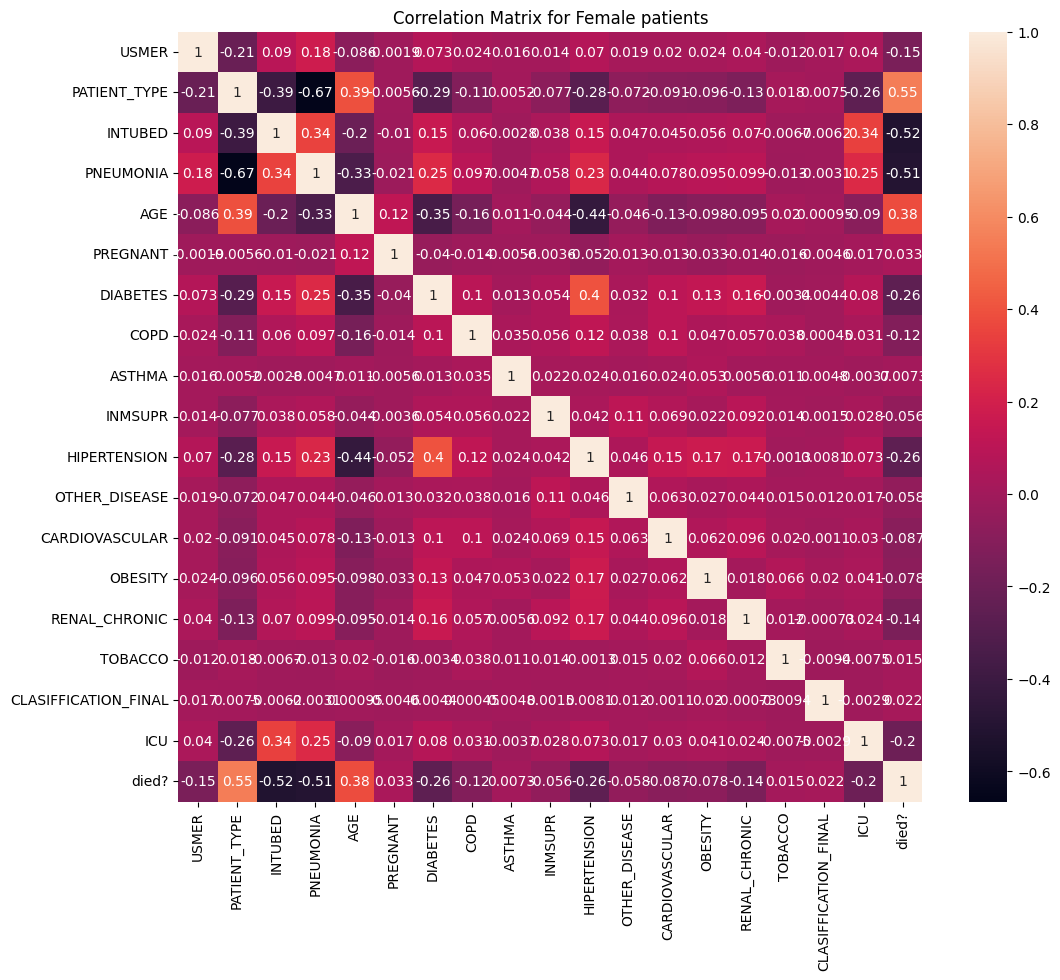

In [204]:
corr_matrix_f= df_female.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_f, annot=True)
plt.title("Correlation Matrix for Female patients");
#Strongest correlations: Patient type, intubed, pnuemonia (STRONGEST), age, followed by diabetes, hypertension

2. Chi-Squared 

In [531]:
#Method 2: Chi-Squared test
#test= X_fem_train.drop(columns= ["AGE"], axis=1)
test= X_fem_train
chi_scores, p_values= chi2(test, y_fem_train)
chi_df= pd.DataFrame({"Features":test.columns, "Chi-square scores":chi_scores, "P-values":p_values})
chi_df= chi_df.sort_values(by="Chi-square scores", ascending=False)
chi_df

#Most important features are patient type, pneumonia, hypertension, intubed, diabetes, usmer

#Less important features include ASTHMA, TOBACCO, PREGNANT, CARDIOVASCULAR, COPD

,Features,Chi-square scores,P-values
4,AGE,128068.734105,0.000000e+00
1,PATIENT_TYPE,33659.439262,0.000000e+00
3,PNEUMONIA,6741.058346,0.000000e+00
10,HIPERTENSION,1951.458457,0.000000e+00
2,INTUBED,1790.388877,0.000000e+00
6,DIABETES,1540.713276,0.000000e+00
0,USMER,1183.864562,1.958843e-259
13,OBESITY,161.914886,4.318012e-37
16,CLASIFFICATION_FINAL,141.725191,1.116787e-32
17,ICU,116.547678,3.606052e-27


3. Lasso Regression (L-1 Regularlization)

In [210]:
lasso= LassoCV(cv=5, random_state=42)
lasso.fit(X_fem_train, y_fem_train)
lasso.coef_
#=0 @ columns: 6,8,9,10,12,13,14,16,17,18
#(Pregnant, COPD, ASTHMA, INMSUPR, HYPERTENSION, OTHER_DISEASE,CARDIOVASCULAR, RENAL CHRONIC, TOBACCO)

array([-0.00696691,  0.15959884, -0.4496285 , -0.13953558,  0.00285391,
        0.        , -0.02252616, -0.        ,  0.        , -0.        ,
       -0.01406997, -0.        , -0.        ,  0.        , -0.01283663,
        0.        ,  0.        ,  0.        ], dtype=float32)

3. Random Forest Classifier Feature Importance 

In [213]:
# This method helps explore NON LINEAR relationships (if any)
class_model= RandomForestClassifier(n_estimators=100, random_state=42)
class_model.fit(X_fem_train, y_fem_train)

feature_importances= class_model.feature_importances_
feature_importance_df= pd.DataFrame({"Feature": X_fem_train.columns, "Importance": feature_importances})
feature_importance_df= feature_importance_df.sort_values("Importance", ascending=False)
feature_importance_df

#Age is shown to have a high importance, as is backed by literature!
#Patient type, intubed, pneumonia, hypertension and diabetes are shown as more important

,Feature,Importance
4,AGE,0.282071
2,INTUBED,0.221248
1,PATIENT_TYPE,0.195748
3,PNEUMONIA,0.129181
10,HIPERTENSION,0.025337
6,DIABETES,0.024832
16,CLASIFFICATION_FINAL,0.017903
0,USMER,0.016686
13,OBESITY,0.015028
17,ICU,0.012589


4. Top Feature Ranking

In [216]:
Features= ["Patient Type", "Intubed","Pneumonia","Age","Diabetes", "Hypertension", "ICU", "USMER"]
CM= [0.55,0.52,0.51,0.38,0.26,0.26,0.20,0.15]
ChiSquared=[33659,1790,6741,128068, 1540, 1951, 240,1818]
RF= [0.28,0.22,0.129,0.28,0.025,0.025,0.012,0.016]
ranking_df= pd.DataFrame({"Feature":Features,
                          "CM": CM,
                         "Chi":ChiSquared,
                         "RF":RF})
ranking_df["Chi"]=ranking_df["Chi"]/100000
ranking_df["Score"]=ranking_df["CM"]+ranking_df["Chi"]+ranking_df["RF"]
ranking_df= ranking_df.sort_values("Score", ascending= False)
ranking_df
#This is used to tabulate the 7 most imporant features for female patients. This value was chosen because many sparsely correlated features introduce noise.
#Resulting tables were used for the results section of the research report write-up .

USMER: -0.2289
PATIENT_TYPE: 2.1641
INTUBED: -2.6463
PNEUMONIA: -1.2071
AGE: 0.0512
PREGNANT: 0.2088
DIABETES: -0.3416
COPD: -0.1694
ASTHMA: 0.0600
INMSUPR: -0.1390
HIPERTENSION: -0.1769
OTHER_DISEASE: -0.2758
CARDIOVASCULAR: -0.0054
OBESITY: -0.1748
RENAL_CHRONIC: -0.8516
TOBACCO: 0.2780
CLASIFFICATION_FINAL: 0.3831
ICU: 0.5292


In [ ]:
plt.style.use("classic")
plot= sns.barplot(x= "Feature", y= "Score", data= ranking_df,color= "r")
plt.xticks(rotation= 45)
plt.title("Top Covid-19 Mortality Predictors- Female");

Findings:
There is consistent agreement that PATIENT_TYPE, INTUBED, AND PNEUMONIA hold the greatest importance.
There is also agreement that Age, diabetes and hypertension hold importance though not quite as significant.

## MALE PATIENTS

In [220]:
X_male= (df_male.iloc[:,:-1]).astype("float32")
y_male= df_male.iloc[:,-1].astype("float32")
X_male_train, X_male_test, y_male_train, y_male_test= train_test_split(X_male, y_male, test_size=0.2, random_state=42)

#Splitting data into train and test

1. Correlation Matrix

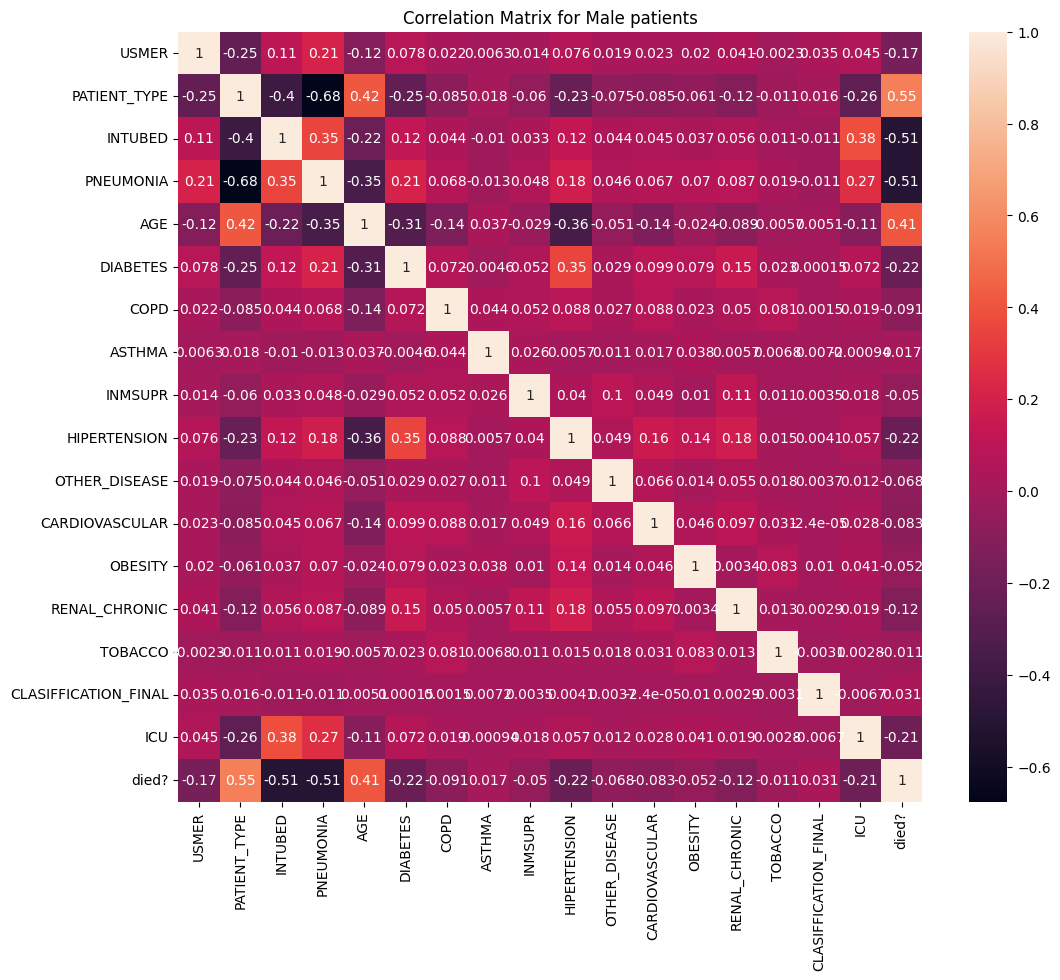

In [223]:
corr_matrix= df_male.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix for Male patients");
#Patient type, intubed, pneumonia, age all have the highest correlations, analagous to that for 
#women

2. Chi-Squared

In [529]:
#test= X_male_train.drop(columns= ["AGE"], axis=1)
test= X_male_train
chi_scores, p_values= chi2(test, y_male_train)
chi_df= pd.DataFrame({"Features":test.columns, "Chi-square scores":chi_scores, "P-values":p_values})
chi_df= chi_df.sort_values(by="Chi-square scores", ascending=False)
chi_df
#Likewise suggests that patient type, pneumonia, intubed most prevelant, followed 
#by less contributing yet still revelant hypertension, diabetes

,Features,Chi-square scores,P-values
4,AGE,168114.597075,0.000000e+00
1,PATIENT_TYPE,34226.536843,0.000000e+00
3,PNEUMONIA,11203.136359,0.000000e+00
2,INTUBED,3215.883090,0.000000e+00
0,USMER,1818.263277,0.000000e+00
9,HIPERTENSION,1555.377312,0.000000e+00
5,DIABETES,1346.526561,8.759575e-295
15,CLASIFFICATION_FINAL,300.746536,2.265307e-67
16,ICU,240.557251,2.973039e-54
12,OBESITY,79.333427,5.246450e-19


3. Lasso Regression (L-1 Regularlization)

In [229]:
lasso= LassoCV(cv=5, random_state=42)
lasso.fit(X_male_train, y_male_train)
lasso.coef_
#Suggests the dropping od diabetes, COPD, ASTHMA, Hypertension, cardiovasculae disease, obesity, 
#renal chronic, tobacco use, ICU

array([-6.05885312e-03,  1.70966581e-01, -4.11768138e-01, -1.52635232e-01,
        4.25696652e-03, -1.53574385e-02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -9.88676026e-03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.51875026e-04,
        0.00000000e+00], dtype=float32)

4. Random Forest Classifier Feature Importance

In [232]:
#Helps explore NON LINEAR relationships (if any)
class_model= RandomForestClassifier(n_estimators=100, random_state=42)
class_model.fit(X_male_train, y_male_train)

feature_importances= class_model.feature_importances_
feature_importance_df= pd.DataFrame({"Feature": X_male_train.columns, "Importance": feature_importances})
feature_importance_df= feature_importance_df.sort_values("Importance", ascending=False)
feature_importance_df
#Patient type, intubed, pneumonia once again are shown as the more important features
#again followed by age and hypertension. Age is shown to be highly important

,Feature,Importance
4,AGE,0.264659
1,PATIENT_TYPE,0.225370
2,INTUBED,0.203154
3,PNEUMONIA,0.155936
5,DIABETES,0.020575
15,CLASIFFICATION_FINAL,0.020011
9,HIPERTENSION,0.017513
0,USMER,0.016156
16,ICU,0.014291
12,OBESITY,0.012747


5. Top Feature Ranking

In [ ]:
Features= ["Patient Type", "Intubed","Pneumonia","Age","Diabetes", "Hypertension", "ICU", "USMER"]
CM= [0.55,0.51,0.51,0.41,0.22,0.22,0.21,0.17]
ChiSquared=[34226,3215,11203,168114,1346,1555,240,1818]
RF= [0.22,0.20,0.15,0.26,0.02,0.017,0.014,0.016]
ranking_df2= pd.DataFrame({"Feature":Features,
                          "CM": CM,
                         "Chi":ChiSquared,
                         "RF":RF})
ranking_df2["Chi"]=ranking_df2["Chi"]/100000
ranking_df2["Score"]=ranking_df2["CM"]+ranking_df["Chi"]+ranking_df["RF"]
ranking_df2= ranking_df2.sort_values("Score", ascending= False)
ranking_df2

#This is used to tabulate the 7 most imporant features for male patients. This value was chosen because many sparsely correlated features introduce noise.
#Resulting tables were used for the results section of the research report write-up .

In [ ]:
plt.style.use("classic")
plot= sns.barplot(x= "Feature", y= "Score", data= ranking_df2)
plt.xticks(rotation= 45)
plt.title("Top Covid-19 Mortality Predictors- Male");

## Discussion: Feature Selection Output
There is high agreement in the overall features contributing towards Covid-19 mortality betweenn men and women.
Patient type, intubed, and pneumonia are all the highest contributors with diabetes and hypertension as runners up.

## 6. Algorithm Modelling

This step of research methodology is to empirically use the feature importances emphasized above as variables in respective machine learning models.
Many of these classification models were chosen according to existing literature, including

-1. XGBoost

-2. Random Forest (RF)

-3. K-Nearest Neighbours (KNN)

-4. Support Vector Machine (SVM)

Other models were chosen to broaden the scope of research, including

-1. Logistic Regression

-2. Artificial Neural Network (ANN)

Once again, this is to be performed seperately for men and women

## 6.1 Data Balancing, Resampling, & Final Feature Engineering

In [242]:
print(f"Percentage of male patients who lived: {100*(len(df_male.loc[df_male["died?"]==0]))/len(df_male):.2f} %")
print(f"Percentage of female patients who lived: {100*(len(df_female.loc[df_female["died?"]==0]))/len(df_female):.2f} %")


Percentage of male patients who lived: 83.16 %
Percentage of female patients who lived: 89.61 %


This shows that the data is heavily imbalanced towards the majority class of patients surviving. If a ML algorithm were to be trained on this dataset, there would be an inherent bias towards memorising and replicating this majority class rather than being able to generalize to raw, unseen data.

SMOTE (Synthetic Minority Class Over-sampling Technique)

In [251]:
smote= SMOTE(random_state=42)
X_fem_train_smote, y_fem_train_smote= smote.fit_resample(X_fem_train, y_fem_train)
X_male_train_smote, y_male_train_smote= smote.fit_resample(X_male_train, y_male_train)
print(len(X_fem_train_smote))

261486


The above feature selection methods have shown for both male and female data-frames, there are many, loosely correlated features. With a dataset size in the hundreds of thousands (shown above), it is likely that a high degree of noise will be present, negatively impacting the performance of ML algorithms. Futhermore, it will act as a high computational expense, particularly if neural network models are to be tested. To ensure a fair test, all algorithms must be trained on the same dataset.

Hence, both male and female training data is largely scaled down by a factor of 5%. This will shrink down the size of the data, but not to the extent that there will be a significant loss in value.

In [255]:
y_train_df_fem=pd.DataFrame(y_fem_train_smote)
smote_df_fem= pd.concat([X_fem_train_smote, y_train_df_fem], axis=1)
shrunk_df_fem= smote_df_fem.sample(frac=0.05)
#Defining Re-scaled testing and training data:
X_train_new_fem= shrunk_df_fem.iloc[:,:-1]
y_train_new_fem= shrunk_df_fem.iloc[:,-1]
len(shrunk_df_fem)

13074

In [257]:
y_train_df_male=pd.DataFrame(y_male_train_smote)
smote_df_male= pd.concat([X_male_train_smote, y_train_df_male], axis=1)
shrunk_df_male= smote_df_male.sample(frac=0.05)
#Defining Re-scaled testing and training data:
X_train_new_male= shrunk_df_male.iloc[:,:-1]
y_train_new_male= shrunk_df_male.iloc[:,-1]
len(shrunk_df_male)

13925

Final dropping of columns

In [260]:
X_train_new_fem= X_train_new_fem.drop(columns= ["PREGNANT", "ASTHMA", "TOBACCO", "OTHER_DISEASE", "COPD","INMSUPR", "RENAL_CHRONIC", "OBESITY", "CLASIFFICATION_FINAL"])
X_fem_test= X_fem_test.drop(columns= ["PREGNANT", "ASTHMA", "TOBACCO", "OTHER_DISEASE", "COPD","INMSUPR","RENAL_CHRONIC", "OBESITY", "CLASIFFICATION_FINAL"])

In [262]:
X_train_new_male= X_train_new_male.drop(columns= ["ASTHMA", "TOBACCO", "OTHER_DISEASE", "COPD","INMSUPR", "RENAL_CHRONIC", "OBESITY", "CLASIFFICATION_FINAL"])
X_male_test= X_male_test.drop(columns= ["ASTHMA", "TOBACCO", "OTHER_DISEASE", "COPD","INMSUPR","RENAL_CHRONIC", "OBESITY", "CLASIFFICATION_FINAL"])

In [264]:
#It has now been established that ANN models will be performed alongside other algorithms.
#ANN algorithms are more sensitive to variance due to the numerous hyper-parameters,
#hence a MinMaxScaler() acts to decrease sensitivity more than StandardScaler().
from sklearn.preprocessing import MinMaxScaler 
scaler= MinMaxScaler()
for col in X_fem_test.columns:
  X_train_new_fem[col]= scaler.fit_transform(X_train_new_fem[[col]])
  X_fem_test[col]= scaler.fit_transform(X_fem_test[[col]])
for col in X_male_test.columns:
  X_train_new_male[col]= scaler.fit_transform(X_train_new_male[[col]])
  X_male_test[col]= scaler.fit_transform(X_male_test[[col]])

In [266]:
#As stated above, many low correlated features introduce noise. Another way of reducing the impact
#of said noise is to scale the more important features by a noticale scaler.
important_features= ["PATIENT_TYPE", "PNEUMONIA", "INTUBED","AGE"] #identified by above feature selection techniques
sub_important_features=["HIPERTENSION", "USMER", "DIABETES"]
scaling_factor= 30
scaling_factor_2=5
scaled_train_fem= X_train_new_fem.copy()
scaled_test_fem= X_fem_test.copy()
scaled_train_male= X_train_new_male.copy()
scaled_test_male= X_male_test.copy()
for col in important_features:
  scaled_train_fem[col]= scaled_train_fem[col]*scaling_factor  #The most important features are being multiplied by the largest scaler
  scaled_test_fem[col]= scaled_test_fem[col]*scaling_factor
  scaled_train_male[col]= scaled_train_male[col]*scaling_factor
  scaled_test_male[col]= scaled_test_male[col]*scaling_factor
for col in sub_important_features:
  scaled_train_fem[col]= scaled_train_fem[col]*scaling_factor_2 #The second most important features (sub important features) are multiplied by the second largest scaler
  scaled_test_fem[col]= scaled_test_fem[col]*scaling_factor_2
  scaled_train_male[col]= scaled_train_male[col]*scaling_factor_2
  scaled_test_male[col]= scaled_test_male[col]*scaling_factor_2

## ALGORITHM TESTING

## FEMALE

1. Random Forest

In [463]:
#1. Random Forest
model1= RandomForestClassifier() #by defualt n estimators= 100 is selected
model1.fit(scaled_train_fem ,y_train_new_fem); #fitting model onto scaled training sets

In [465]:
y_pred= model1.predict_proba(scaled_test_fem)
y_pred_thresh= (y_pred[:, 1] >= 0.6) #Threshold may be needed, as test data is 
#still imbalanced! It is poor pratice to apply SMOTE to testing data.
#Because of the test data imbalance, important metrics being considered are F-1 score
#and pr_auc

In [467]:
precision1, recall1, _ = precision_recall_curve(y_fem_test, y_pred[:, 1] )
pr_auc1 = auc(recall, precision)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc1}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred_thresh)}")

F-1 Score: 0.5099594868332208
Pr-Auc: 0.613358353077925
Accurcay Score: 0.8409227902898789


2. XGBoost

In [470]:
model2= XGBClassifier(max_depth=3, learning_rate= 0.01) #max depth =3 was chosen to mitigate over-fitting.
model2.fit(scaled_train_fem ,y_train_new_fem);
y_pred=model2.predict_proba(scaled_test_fem)
y_pred_thresh = (y_pred[:, 1] >= 0.5).astype(int) #Converting all probailities into either 1/0 depending on chosen threshold.
precision2, recall2, _ = precision_recall_curve(y_fem_test, y_pred[:, 1] )
pr_auc2 = auc(recall2, precision2)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc2}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred_thresh)}")

F-1 Score: 0.5974250410438089
Pr-Auc: 0.7064637016285595
Accurcay Score: 0.8723491698175242


3. Logistic Regression

In [473]:
model3= LogisticRegression(max_iter=500)
model3.fit(scaled_train_fem ,y_train_new_fem)
y_pred= model3.predict_proba(scaled_test_fem)
y_pred_thresh = (y_pred[:, 1] >= 0.95).astype(int)
precision3, recall3, _ = precision_recall_curve(y_fem_test, y_pred[:, 1] )
pr_auc3 = auc(recall3, precision3)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc3}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred_thresh)}")

F-1 Score: 0.5633755274261604
Pr-Auc: 0.7075914441997718
Accurcay Score: 0.9291194038029481


4. Support Vector Machine

In [476]:
model4= SVC(kernel="rbf", probability=True) #RBF kernel chosen to map out non-linearly seperable data into higher dimensions.
model4.fit(scaled_train_fem ,y_train_new_fem)
y_pred= model4.predict_proba(scaled_test_fem)
y_pred_thresh = (y_pred[:, 1] >= 0.6).astype(int)
precision4, recall4, _ = precision_recall_curve(y_fem_test, y_pred[:, 1] )
pr_auc4 = auc(recall4, precision4)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc4}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred_thresh)}")

F-1 Score: 0.6079200856225473
Pr-Auc: 0.5183215224345468
Accurcay Score: 0.8795550441120061


5. KNN (K-Nearest Neighbours)

In [479]:
model5= KNeighborsClassifier(n_neighbors=5) #Odd number of neighbours chosen for adequate ensemble voting.
model5.fit(scaled_train_fem ,y_train_new_fem)
y_pred= model5.predict_proba(scaled_test_fem)
y_pred_thresh = (y_pred[:, 1] >= 0.5).astype(int)
precision5, recall5, _ = precision_recall_curve(y_fem_test, y_pred[:, 1] )
pr_auc5 = auc(recall5, precision5)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc5}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred_thresh)}")

F-1 Score: 0.6058686539357243
Pr-Auc: 0.6533551389506933
Accurcay Score: 0.8840758397720423


6. Artificial Neural Network (ANN)

In [533]:
model6= keras.models.Sequential()
model6.add(keras.layers.Dense(units=32, activation= "relu")) #The ReLU layer has been implemented to introduce non-linearity to the model
model6.add(keras.layers.Dense(units=16, activation= "relu"))
model6.add(keras.layers.Dropout(0.25)) #Random neuron deactivation prevents both over fitting and high computaitional expense.
model6.add(keras.layers.Dense(units=8, activation= "relu"))
model6.add(keras.layers.Dense(units = 1, activation = 'sigmoid')) #Outcome prediction is between 0-1
model6.compile(optimizer= "Adam", loss= "binary_crossentropy", metrics= ["precision", "recall"])
#AUC is an appropriate 

In [535]:
EarlyStop= EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True) #Used as a call-back, to prevent the model from overfitting
#provided that during testing, error improvement plateaus across 20 epochs.

In [537]:
model6.fit(scaled_train_fem ,y_train_new_fem, batch_size=10, epochs=100) #100 epochs chosen as a trade-off between complexity and training time.

Epoch 1/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.3242 - precision: 0.8459 - recall: 0.8894
Epoch 2/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2628 - precision: 0.8639 - recall: 0.9553
Epoch 3/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2566 - precision: 0.8694 - recall: 0.9551
Epoch 4/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2509 - precision: 0.8727 - recall: 0.9561
Epoch 5/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2463 - precision: 0.8769 - recall: 0.9511
Epoch 6/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2514 - precision: 0.8697 - recall: 0.9503
Epoch 7/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2437 - precision: 0.8749 - recall: 0.9503
Epoch 8/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2384 - precision: 0.8823 - recall: 0.9467
Epoch 9/100
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2432 - precision: 0.8758 - recall: 0.9506
Epoch 10/100
1308/1308 ━━━━━━━━━━━━━

In [555]:

y_pred= model6.predict(scaled_test_fem)
y_pred= (y_pred <0.05).astype(int)

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [557]:
precision6, recall6, _ = precision_recall_curve(y_fem_test, y_pred)
pr_auc6 = auc(recall6, precision6)
print(f"F-1 Score: {f1_score(y_fem_test, y_pred)}")
print(f"Pr-Auc: {pr_auc6}")
print(f"Accurcay Score: {accuracy_score(y_fem_test, y_pred)}")

F-1 Score: 0.0013403542364767832
Pr-Auc: 0.05292715436910021
Accurcay Score: 0.4284070360019727


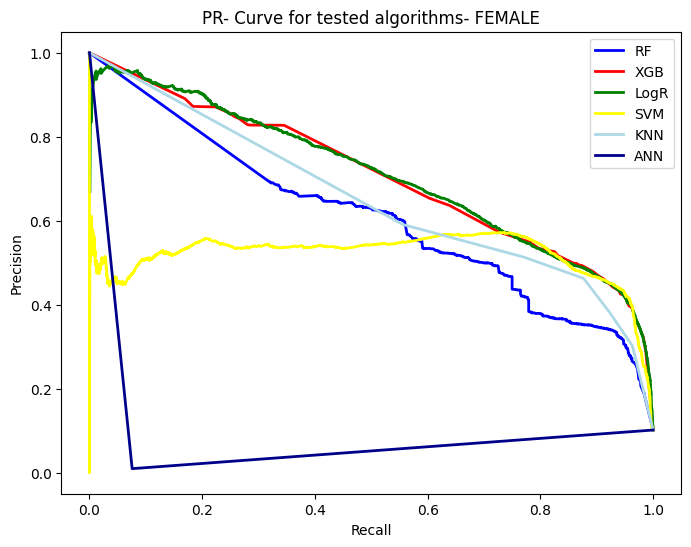

In [492]:
plt.figure(figsize=(8, 6))
plt.plot(recall1, precision1, label="RF", color='blue', lw=2)
plt.plot(recall2, precision2, label="XGB", color='red', lw=2)
plt.plot(recall3, precision3, label="LogR", color='green', lw=2)
plt.plot(recall4, precision4, label="SVM", color='yellow', lw=2)
plt.plot(recall5, precision5, label="KNN", color='lightblue', lw=2)
plt.plot(recall6, precision6, label="ANN", color='darkblue', lw=2)
plt.legend()
plt.title("PR- Curve for tested algorithms- FEMALE")
plt.xlabel("Recall")
plt.ylabel("Precision");
#This takes every precision and recall values (across each model) and plots the respecive PR- curves to compare and contrast model performance
#in terms of predicting both classes of output data.

## MALE

Random Forest

In [494]:
#1. Random Forest
model1= RandomForestClassifier()
model1.fit(scaled_train_male,y_train_new_male);

In [496]:
y_pred= model1.predict_proba(scaled_test_male)
y_pred_thresh= (y_pred[:, 1] >= 0.6).astype(int)
precision1, recall1, _ = precision_recall_curve(y_male_test, y_pred[:, 1] )
pr_auc_1 = auc(recall1, precision1)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_1}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.6058406387849684
Pr-Auc: 0.6692405852566502
Accurcay Score: 0.8315194042675068


XGBoost

In [499]:
model2= XGBClassifier(max_depth=3, learning_rate= 0.01)
model2.fit(scaled_train_male,y_train_new_male)
y_pred=model2.predict_proba(scaled_test_male)
y_pred_thresh = (y_pred[:, 1] >= 0.3).astype(int);

In [501]:
y_pred= model2.predict_proba(scaled_test_male)
y_pred_thresh= (y_pred[:, 1] >= 0.7).astype(int)
precision2, recall2, _ = precision_recall_curve(y_male_test, y_pred[:, 1] )
pr_auc_2 = auc(recall2, precision2)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_2}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.510548523206751
Pr-Auc: 0.7483259484050835
Accurcay Score: 0.8837175998854361


Logistic Regression

In [504]:
model3= LogisticRegression(max_iter=500)
model3.fit(scaled_train_male,y_train_new_male)
y_pred= model3.predict_proba(scaled_test_male)
y_pred_thresh = (y_pred[:, 1] >= 0.95).astype(int);

In [506]:
y_pred= model3.predict_proba(scaled_test_male)
y_pred_thresh= (y_pred[:, 1] >= 0.7).astype(int)
precision3, recall3, _ = precision_recall_curve(y_male_test, y_pred[:, 1] )
pr_auc_3= auc(recall3, precision3)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_3}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.6732660538664267
Pr-Auc: 0.7425933041650834
Accurcay Score: 0.8786815599789967


Support-Vector Machine

In [509]:
model4= SVC(kernel="rbf", probability=True)
model4.fit(scaled_train_male,y_train_new_male);

In [513]:
y_pred= model4.predict_proba(scaled_test_male)
y_pred_thresh = (y_pred[:, 1] >= 0.6).astype(int)
precision4, recall4, _ = precision_recall_curve(y_male_test, y_pred[:, 1] )
pr_auc_4= auc(recall4, precision4)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_4}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.6571065721240343
Pr-Auc: 0.6124466393412564
Accurcay Score: 0.84533867965058


KNN 

In [429]:
model5= KNeighborsClassifier(n_neighbors=5)
model5.fit(scaled_train_male,y_train_new_male);

In [515]:
y_pred= model5.predict_proba(scaled_test_male)
y_pred_thresh = (y_pred[:, 1] >= 0.6).astype(int)
precision5, recall5, _ = precision_recall_curve(y_male_test, y_pred[:, 1] )
pr_auc_5= auc(recall5, precision5)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_5}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.6564532128292737
Pr-Auc: 0.6981624886269282
Accurcay Score: 0.851210081626808


In [517]:
model6= keras.models.Sequential()
model6.add(keras.layers.Dense(units=32, activation= "relu"))
model6.add(keras.layers.Dense(units=16, activation= "relu"))
model6.add(keras.layers.Dropout(0.25))
model6.add(keras.layers.Dense(units=8, activation= "relu"))
model6.add(keras.layers.Dense(units = 1, activation = 'sigmoid')) #Outcome prediction is between 0-1
model6.compile(optimizer= "Adam", loss= "binary_crossentropy", metrics= ["precision", "recall"])

In [519]:
EarlyStop= EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)

In [521]:
model6.fit(scaled_train_male ,y_train_new_male, batch_size=10, epochs=100)

Epoch 1/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4421 - precision: 0.7606 - recall: 0.8774
Epoch 2/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3277 - precision: 0.8267 - recall: 0.9145
Epoch 3/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3275 - precision: 0.8249 - recall: 0.9182
Epoch 4/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3244 - precision: 0.8298 - recall: 0.9217
Epoch 5/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3179 - precision: 0.8307 - recall: 0.9250
Epoch 6/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3214 - precision: 0.8295 - recall: 0.9213
Epoch 7/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3102 - precision: 0.8335 - recall: 0.9323
Epoch 8/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3162 - precision: 0.8314 - recall: 0.9352
Epoch 9/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3208 - precision: 0.8282 - recall: 0.9197
Epoch 10/100
1393/1393 ━━━━━━━━━━━━━━

In [523]:
y_pred= model6.predict(scaled_test_male)
y_pred= (y_pred <0.7).astype(int)

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [525]:
precision6, recall6, _ = precision_recall_curve(y_male_test, y_pred)
pr_auc_6= auc(recall6, precision6)
print(f"F-1 Score: {f1_score(y_male_test, y_pred_thresh)}")
print(f"Pr-Auc: {pr_auc_6}")
print(f"Accurcay Score: {accuracy_score(y_male_test, y_pred_thresh)}")

F-1 Score: 0.6564532128292737
Pr-Auc: 0.2154352821890726
Accurcay Score: 0.851210081626808


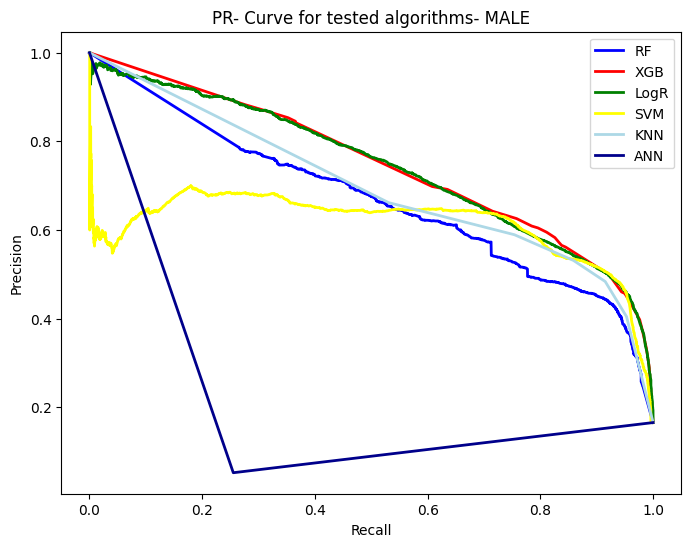

In [527]:
plt.figure(figsize=(8, 6))
plt.plot(recall1, precision1, label="RF", color='blue', lw=2)
plt.plot(recall2, precision2, label="XGB", color='red', lw=2)
plt.plot(recall3, precision3, label="LogR", color='green', lw=2)
plt.plot(recall4, precision4, label="SVM", color='yellow', lw=2)
plt.plot(recall5, precision5, label="KNN", color='lightblue', lw=2)
plt.plot(recall6, precision6, label="ANN", color='darkblue', lw=2)
plt.legend()
plt.title("PR- Curve for tested algorithms- MALE")
plt.xlabel("Recall")
plt.ylabel("Precision");